In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
import pyro.infer
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import os

pyro.set_rng_seed(42)
torch.manual_seed(42)
np.random.seed(42)

downlink_file = "./data/processed/processed_downlink_all.csv"
downlink_df = pd.read_csv(downlink_file)

print(f"Loaded {len(downlink_df)} rows from {downlink_file}")
print(downlink_df.columns)
downlink_df.head()

Loaded 521294 rows from ./data/processed/processed_downlink_all.csv
Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'app_name', 'file_name', 'timestamp', 'direction', 'inter_arrival_time',
       'inter_arrival_ms'],
      dtype='object')


,No.,Time,Source,Destination,Protocol,Length,Info,app_name,file_name,timestamp,direction,inter_arrival_time,inter_arrival_ms
0,6,2022-08-09 23:30:02.398435,10.215.173.2,10.215.173.1,DNS,276,Standard query response 0x02cd A sdk.iad-05.br...,Zepeto,Zepeto_7.csv,2022-08-09 23:30:02.398435,downlink,0 days 00:00:00.021355,21.355
1,9,2022-08-09 23:30:02.445874,146.75.50.133,10.215.173.1,TCP,48,"443 > 36154 [SYN, ACK] Seq=0 Ack=1 Win=2048 ...",Zepeto,Zepeto_7.csv,2022-08-09 23:30:02.445874,downlink,0 days 00:00:00.047439,47.439
2,12,2022-08-09 23:30:02.448454,146.75.50.133,10.215.173.1,TCP,40,443 > 36154 [ACK] Seq=1 Ack=518 Win=2096128 ...,Zepeto,Zepeto_7.csv,2022-08-09 23:30:02.448454,downlink,0 days 00:00:00.002580,2.580
3,13,2022-08-09 23:30:02.463716,146.75.50.133,10.215.173.1,TCP,48,"443 > 36156 [SYN, ACK] Seq=0 Ack=1 Win=2048 ...",Zepeto,Zepeto_7.csv,2022-08-09 23:30:02.463716,downlink,0 days 00:00:00.015262,15.262
4,16,2022-08-09 23:30:02.465784,146.75.50.133,10.215.173.1,TCP,40,443 > 36156 [ACK] Seq=1 Ack=518 Win=2096128 ...,Zepeto,Zepeto_7.csv,2022-08-09 23:30:02.465784,downlink,0 days 00:00:00.002068,2.068


Original data points: 521294
Filtered data points: 495229
Mean: 78.97 ms, Median: 18.86 ms
Min: 0.02 ms, Max: 1008.99 ms


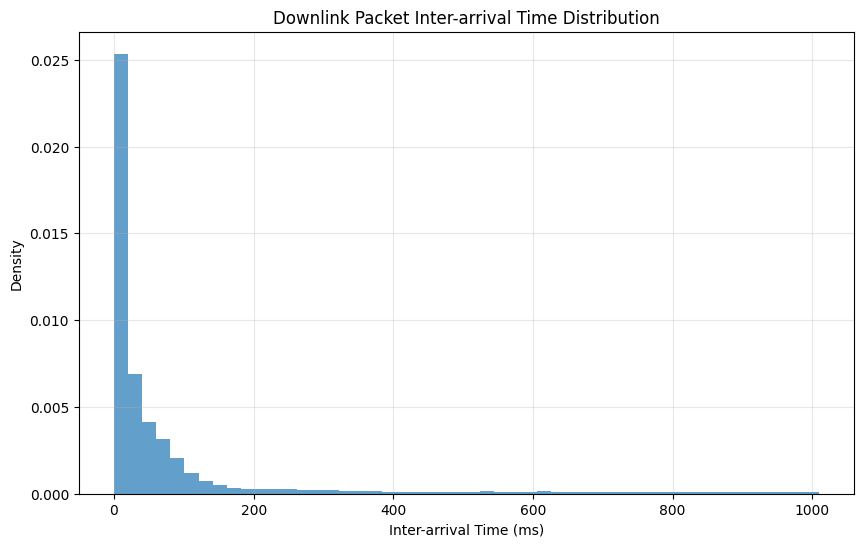

In [2]:
# Extract and prepare the data
if 'inter_arrival_ms' in downlink_df.columns:
    inter_arrival_times = downlink_df['inter_arrival_ms'].dropna().values
elif 'inter_arrival_time' in downlink_df.columns:
    try:
        inter_arrival_times = pd.to_numeric(downlink_df['inter_arrival_time']).values
    except:
        def convert_timedelta_to_ms(td_str):
            if isinstance(td_str, (int, float)):
                return float(td_str)
            try:
                parts = td_str.split()
                if len(parts) >= 3:
                    days = int(parts[0])
                    time_parts = parts[2].split(':')
                    hours = int(time_parts[0])
                    minutes = int(time_parts[1])
                    seconds = float(time_parts[2])
                    
                    total_ms = (days*86400 + hours*3600 + minutes*60 + seconds) * 1000
                    return total_ms
                else:
                    return float(td_str)
            except:
                return np.nan
        
        downlink_df['inter_arrival_ms'] = downlink_df['inter_arrival_time'].apply(convert_timedelta_to_ms)
        inter_arrival_times = downlink_df['inter_arrival_ms'].dropna().values
else:
    print("Error: No inter-arrival time column found in the data")
    
# Filter out extreme values
threshold = np.percentile(inter_arrival_times, 95)
filtered_data = inter_arrival_times[inter_arrival_times < threshold]
print(f"Original data points: {len(inter_arrival_times)}")
print(f"Filtered data points: {len(filtered_data)}")
print(f"Mean: {np.mean(filtered_data):.2f} ms, Median: {np.median(filtered_data):.2f} ms")
print(f"Min: {np.min(filtered_data):.2f} ms, Max: {np.max(filtered_data):.2f} ms")

data_tensor = torch.tensor(filtered_data, dtype=torch.float)

plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=50, density=True, alpha=0.7)
plt.title("Downlink Packet Inter-arrival Time Distribution")
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.show()

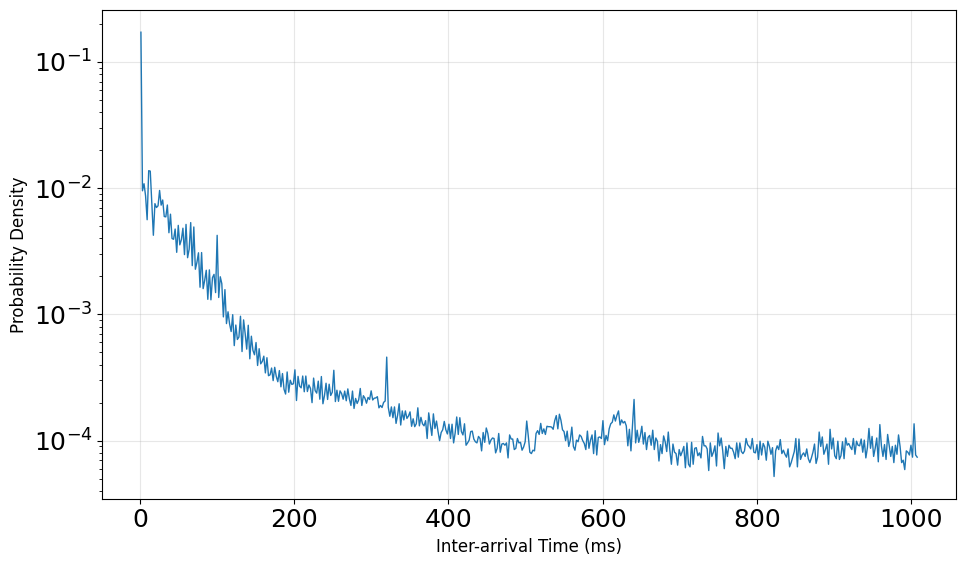

In [17]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10, 6))
counts, bin_edges = np.histogram(filtered_data, bins=500, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.semilogy(bin_centers, counts, linewidth=1)
plt.xlabel("Inter-arrival Time (ms)", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.show()
plt.savefig("mv_dl_traffic.png")

In [4]:
# Exponential
def exponential_model(data=None):
    rate = pyro.sample("rate", dist.Gamma(1.0, 1.0))
    with pyro.plate("data", len(data) if data is not None else 1):
        return pyro.sample("obs", dist.Exponential(rate), obs=data)

# Gamma Model
def gamma_model(data=None):
    alpha = pyro.sample("alpha", dist.Gamma(1.0, 1.0))
    beta = pyro.sample("beta", dist.Gamma(1.0, 1.0))
    with pyro.plate("data", len(data) if data is not None else 1):
        return pyro.sample("obs", dist.Gamma(alpha, beta), obs=data)

Running MAP for Exponential model...
Step 0: loss = 38375824.0000
Step 100: loss = 141204688.0000
Step 200: loss = 7366329.5000
Step 300: loss = 4186637.0000
Step 400: loss = 59895680.0000
Step 500: loss = 16527647.0000
Step 600: loss = 8745020.0000
Step 700: loss = 45403896.0000
Step 800: loss = 45144416.0000
Step 900: loss = 14974650.0000
Step 1000: loss = 28301676.0000
Step 1100: loss = 4663859.5000
Step 1200: loss = 46558632.0000
Step 1300: loss = 23957016.0000
Step 1400: loss = 13273913.0000
Step 1500: loss = 40826212.0000
Step 1600: loss = 51833660.0000
Step 1700: loss = 101551288.0000
Step 1800: loss = 53241368.0000
Step 1900: loss = 20556908.0000
Step 2000: loss = 18625028.0000
Step 2100: loss = 18417182.0000
Step 2200: loss = 72477160.0000
Step 2300: loss = 19150532.0000
Step 2400: loss = 23734428.0000
Step 2500: loss = 55247972.0000
Step 2600: loss = 65277636.0000
Step 2700: loss = 32125184.0000
Step 2800: loss = 31191296.0000
Step 2900: loss = 3835144.5000
Step 3000: loss = 

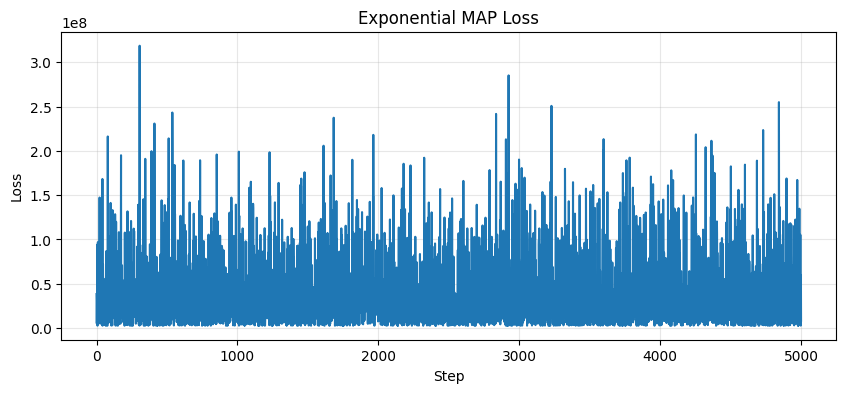

Running MAP for Gamma model...
Step 0: loss = 18337802.0000
Step 100: loss = 6778442.5000
Step 200: loss = 45543184.0000
Step 300: loss = 17041860.0000
Step 400: loss = 66033176.0000
Step 500: loss = 46888336.0000
Step 600: loss = 109769048.0000
Step 700: loss = 40602420.0000
Step 800: loss = 56657284.0000
Step 900: loss = 19705530.0000
Step 1000: loss = 17701274.0000
Step 1100: loss = 25981394.0000
Step 1200: loss = 42440384.0000
Step 1300: loss = 5513372.0000
Step 1400: loss = 2807569.2500
Step 1500: loss = 9683078.0000
Step 1600: loss = 3449692.5000
Step 1700: loss = 13499005.0000
Step 1800: loss = 7914826.5000
Step 1900: loss = 52547120.0000
Step 2000: loss = 35927284.0000
Step 2100: loss = 22499766.0000
Step 2200: loss = 34241444.0000
Step 2300: loss = 32400224.0000
Step 2400: loss = 20741636.0000
Step 2500: loss = 36255912.0000
Step 2600: loss = 14244067.0000
Step 2700: loss = 2393809.7500
Step 2800: loss = 33781712.0000
Step 2900: loss = 4435479.0000
Step 3000: loss = 33524426.0

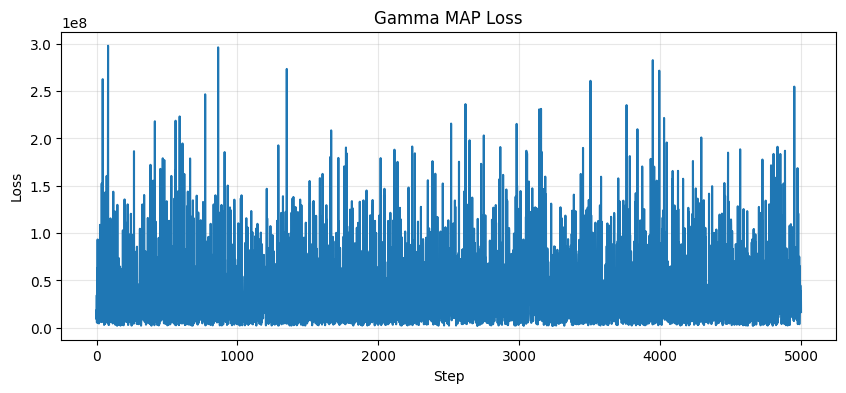

In [5]:
import pyro.infer.autoguide
def run_map(model, data, num_steps=5000):
    pyro.clear_param_store()
    auto_guide = pyro.infer.autoguide.AutoNormal(model)
    
    def map_loss(model, guide, data):
        trace = pyro.poutine.trace(model).get_trace(data)
        return -trace.log_prob_sum()
    
    optimizer = Adam({"lr": 0.01})
    svi = SVI(model, auto_guide, optimizer, loss=map_loss)
    
    losses = []
    for step in range(num_steps):
        loss = svi.step(data)
        losses.append(loss)
        if step % 100 == 0:
            print(f"Step {step}: loss = {loss:.4f}")
    
    posterior = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1000)
    posterior_samples = posterior(data)
    
    params = {}
    for param_name in posterior_samples:
        if param_name != "obs":
            params[param_name] = posterior_samples[param_name].mean().item()
    
    return params, losses

# MAP for Exponential model
print("Running MAP for Exponential model...")
exp_map_params, exp_map_losses = run_map(exponential_model, data_tensor, num_steps=5000)
print(f"Exponential MAP parameters: {exp_map_params}")
plt.figure(figsize=(10, 4))
plt.plot(exp_map_losses)
plt.title("Exponential MAP Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

# MAP for Gamma model
print("Running MAP for Gamma model...")
gamma_map_params, gamma_map_losses = run_map(gamma_model, data_tensor, num_steps=5000)
print(f"Gamma MAP parameters: {gamma_map_params}")
plt.figure(figsize=(10, 4))
plt.plot(gamma_map_losses)
plt.title("Gamma MAP Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

Running Variational Inference for Exponential model...
Step 0: ELBO loss = 32904210.8614
Step 100: ELBO loss = 18136506.6233
Step 200: ELBO loss = 9356093.2877
Step 300: ELBO loss = 7481743.0418
Step 400: ELBO loss = 5626444.4512
Step 500: ELBO loss = 4955503.6684
Step 600: ELBO loss = 3761567.9591
Step 700: ELBO loss = 3617000.0312
Step 800: ELBO loss = 3573832.5239
Step 900: ELBO loss = 3261742.3810
Step 1000: ELBO loss = 3195759.6639
Step 1100: ELBO loss = 3002170.8893
Step 1200: ELBO loss = 2870575.3722
Step 1300: ELBO loss = 2855022.6156
Step 1400: ELBO loss = 2826722.5154
Step 1500: ELBO loss = 2750319.2793
Step 1600: ELBO loss = 2736611.3386
Step 1700: ELBO loss = 2746141.5982
Step 1800: ELBO loss = 2705532.7592
Step 1900: ELBO loss = 2687747.2003
Step 2000: ELBO loss = 2709181.9742
Step 2100: ELBO loss = 2672921.7559
Step 2200: ELBO loss = 2673340.2121
Step 2300: ELBO loss = 2664155.6595
Step 2400: ELBO loss = 2681856.4606
Step 2500: ELBO loss = 2665631.0227
Step 2600: ELBO los

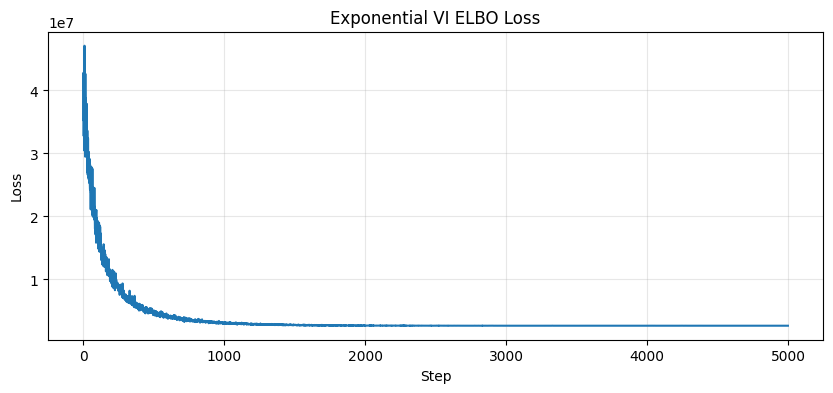

Running Variational Inference for Gamma model...
Step 0: ELBO loss = 35731980.3476
Step 100: ELBO loss = 16453377.6173
Step 200: ELBO loss = 11433111.7691
Step 300: ELBO loss = 7492507.4466
Step 400: ELBO loss = 6078363.6313
Step 500: ELBO loss = 5031010.9778
Step 600: ELBO loss = 4011456.8395
Step 700: ELBO loss = 3712895.9869
Step 800: ELBO loss = 3552634.7353
Step 900: ELBO loss = 3131721.5034
Step 1000: ELBO loss = 2928182.1129
Step 1100: ELBO loss = 2915167.1502
Step 1200: ELBO loss = 2731352.6789
Step 1300: ELBO loss = 2685821.0135
Step 1400: ELBO loss = 2563007.8184
Step 1500: ELBO loss = 2573974.4092
Step 1600: ELBO loss = 2526563.3286
Step 1700: ELBO loss = 2483649.1368
Step 1800: ELBO loss = 2457889.9470
Step 1900: ELBO loss = 2429031.0378
Step 2000: ELBO loss = 2397374.1150
Step 2100: ELBO loss = 2355436.2607
Step 2200: ELBO loss = 2353180.9417
Step 2300: ELBO loss = 2332060.8817
Step 2400: ELBO loss = 2309399.6143
Step 2500: ELBO loss = 2323541.7269
Step 2600: ELBO loss = 2

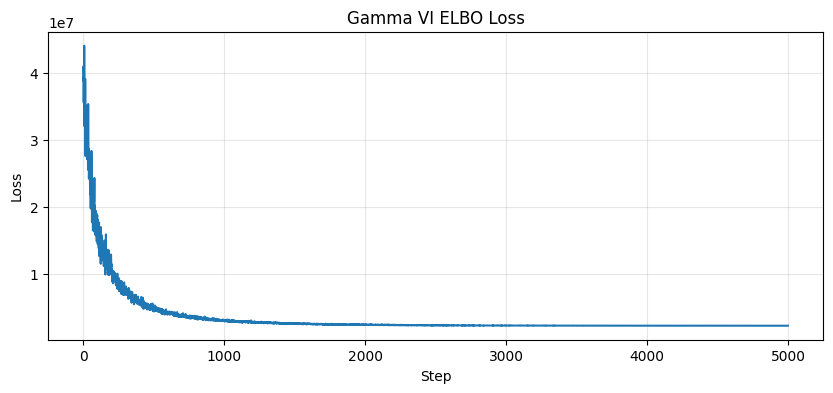

In [6]:
def run_vi(model, data, guide_type="auto", num_steps=5000):
    pyro.clear_param_store()
    if guide_type == "auto":
        guide = pyro.infer.autoguide.AutoNormal(model)
    elif guide_type == "mean_field":
        guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
    elif guide_type == "lowrank":
        guide = pyro.infer.autoguide.AutoLowRankMultivariateNormal(model)
    else:
        raise ValueError(f"Unknown guide type: {guide_type}")
    
    # Setup SVI
    optimizer = Adam({"lr": 0.01})
    elbo = Trace_ELBO()
    svi = SVI(model, guide, optimizer, loss=elbo)
    
    losses = []
    for step in range(num_steps):
        loss = svi.step(data)
        losses.append(loss)
        if step % 100 == 0:
            print(f"Step {step}: ELBO loss = {loss:.4f}")
    posterior = pyro.infer.Predictive(model, guide=guide, num_samples=1000)
    posterior_samples = posterior(data)
    
    params = {}
    for param_name in posterior_samples:
        if param_name != "obs":
            params[param_name] = posterior_samples[param_name].mean(dim=0)
    return guide, posterior_samples, params, losses

# VI for Exponential model
print("Running Variational Inference for Exponential model...")
exp_guide, exp_posterior, exp_vi_params, exp_vi_losses = run_vi(
    exponential_model, data_tensor, guide_type="auto", num_steps=5000
)
print(f"Exponential VI parameters: {exp_vi_params}")
plt.figure(figsize=(10, 4))
plt.plot(exp_vi_losses)
plt.title("Exponential VI ELBO Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

# VI for Gamma model
print("Running Variational Inference for Gamma model...")
gamma_guide, gamma_posterior, gamma_vi_params, gamma_vi_losses = run_vi(
    gamma_model, data_tensor, guide_type="auto", num_steps=5000
)
print(f"Gamma VI parameters: {gamma_vi_params}")
plt.figure(figsize=(10, 4))
plt.plot(gamma_vi_losses)
plt.title("Gamma VI ELBO Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.item()}")

AutoNormal.locs.alpha: -1.184511423110962
AutoNormal.scales.alpha: 0.01271903607994318
AutoNormal.locs.beta: -5.47868537902832
AutoNormal.scales.beta: 0.059336189180612564


Parameters for exponential: {'rate': 1.009737253189087}


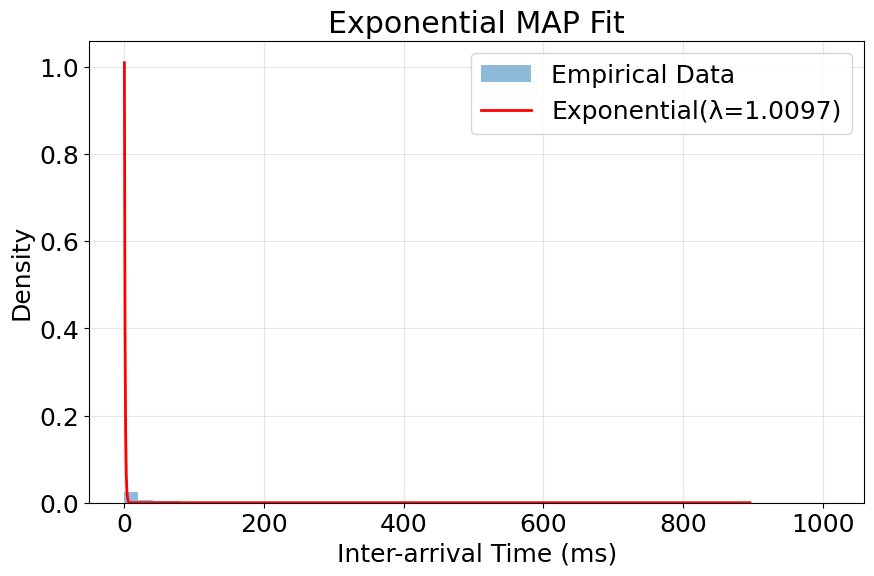

Parameters for gamma: {'alpha': 1.005839467048645, 'beta': 1.0032048225402832}


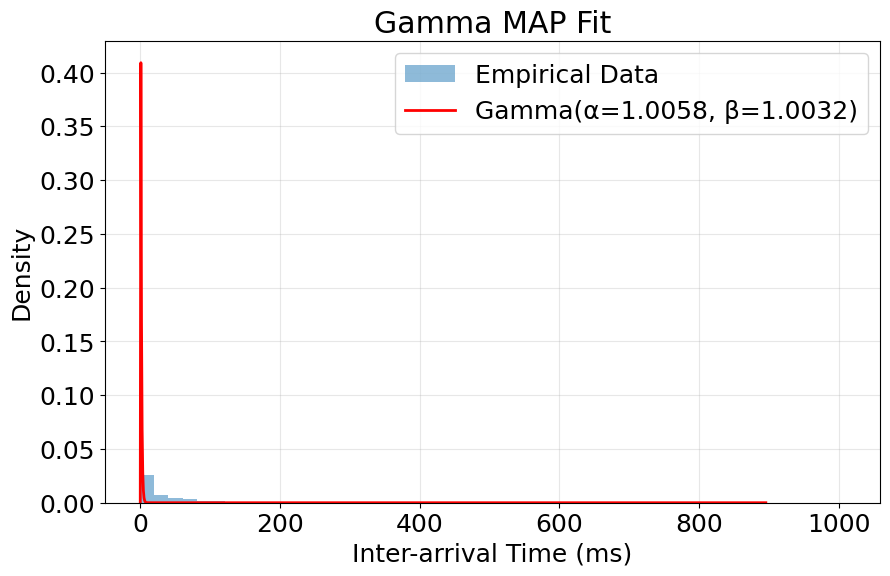

Parameters for exponential: {'rate': tensor([0.0126])}


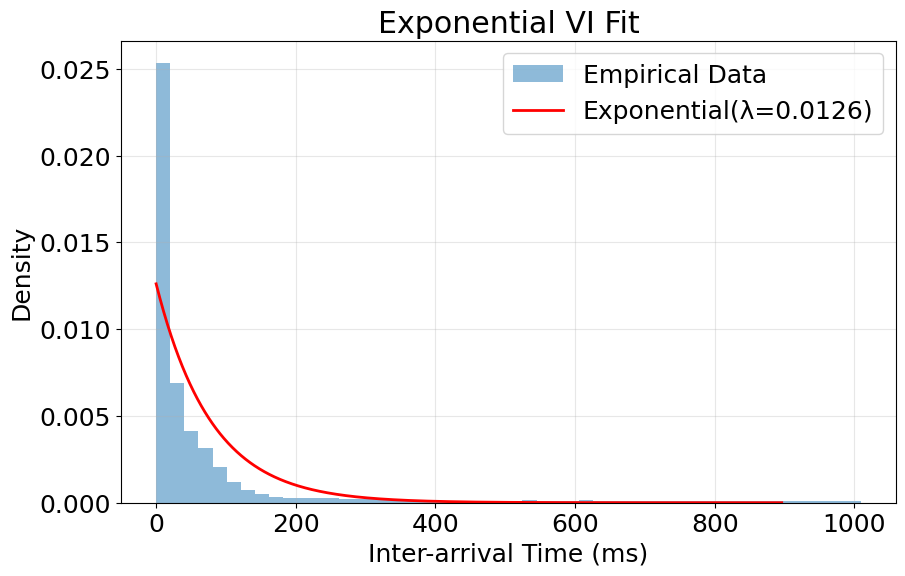

Parameters for gamma: {'alpha': tensor([0.3059]), 'beta': tensor([0.0042])}


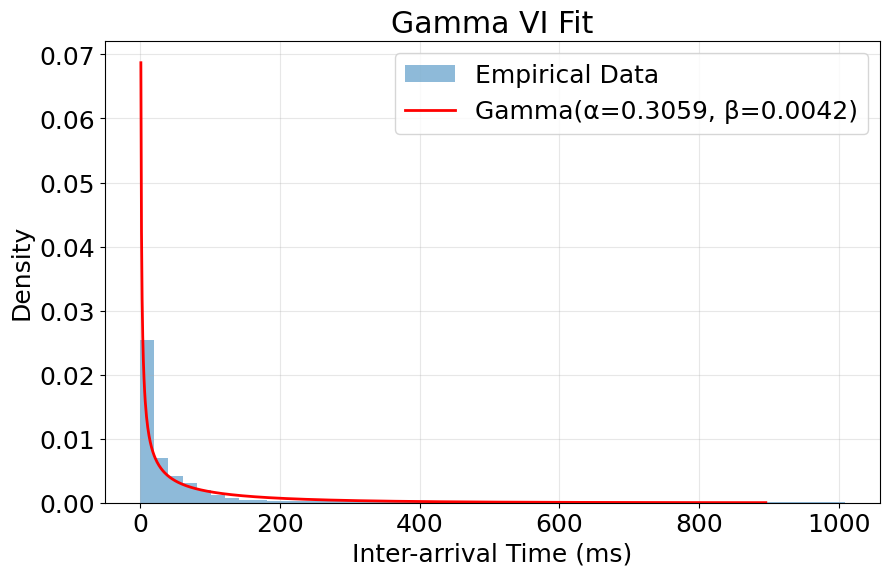


KL Divergence (lower is better):
Exponential MAP: 4.287129
Gamma MAP: 4.324426
Exponential VI: 0.423199
Gamma VI: 0.121158

Best model: Gamma VI with KL Divergence: 0.121158


In [13]:
from scipy import stats

def plot_distribution_fit(data, model_name, params, title=None):
    plt.figure(figsize=(10, 6))
    # Plot empirical histogram
    plt.hist(data.numpy(), bins=50, density=True, alpha=0.5, label='Empirical Data')
    
    # Plot the fitted distribution
    x = np.linspace(0, np.percentile(data.numpy(), 99), 1000)
    print(f"Parameters for {model_name}: {params}")
    if model_name == "exponential":
        rate = params["rate"]
        if torch.is_tensor(rate):
            rate = rate.item()
        y = stats.expon.pdf(x, scale=1/rate)
        dist_label = f"Exponential(λ={rate:.4f})"
    elif model_name == "gamma":
        alpha = params["alpha"]
        beta = params["beta"]
        if torch.is_tensor(alpha):
            alpha = alpha.item()
        if torch.is_tensor(beta):
            beta = beta.item()
        y = stats.gamma.pdf(x, a=alpha, scale=1/beta)
        dist_label = f"Gamma(α={alpha:.4f}, β={beta:.4f})"
    
    plt.plot(x, y, 'r-', linewidth=2, label=dist_label)
    if title:
        plt.title(title)
    else:
        plt.title(f"{model_name.capitalize()} Distribution Fit")
    plt.xlabel("Inter-arrival Time (ms)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def compute_kl_divergence(data, model_name, params, num_bins=50):
    # Compute empirical histogram
    hist, bin_edges = np.histogram(data.numpy(), bins=num_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Compute theoretical PDF
    if model_name == "exponential":
        rate = params["rate"]
        if torch.is_tensor(rate):
            rate = rate.item()
        theoretical_pdf = stats.expon.pdf(bin_centers, scale=1/rate)
    elif model_name == "gamma":
        alpha = params["alpha"]
        beta = params["beta"]
        if torch.is_tensor(alpha):
            alpha = alpha.item()
        if torch.is_tensor(beta):
            beta = beta.item()
        theoretical_pdf = stats.gamma.pdf(bin_centers, a=alpha, scale=1/beta)

    epsilon = 1e-10
    p = hist + epsilon
    q = theoretical_pdf + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    kl_div = np.sum(p * np.log(p / q))
    return kl_div

# Plot MAP model fits
plot_distribution_fit(data_tensor, "exponential", exp_map_params, "Exponential MAP Fit")
plot_distribution_fit(data_tensor, "gamma", gamma_map_params, "Gamma MAP Fit")
# Plot VI model fits
plot_distribution_fit(data_tensor, "exponential", exp_vi_params, "Exponential VI Fit")
plot_distribution_fit(data_tensor, "gamma", gamma_vi_params, "Gamma VI Fit")
# Compute KL divergence for all models
exp_map_kl = compute_kl_divergence(data_tensor, "exponential", exp_map_params)
gamma_map_kl = compute_kl_divergence(data_tensor, "gamma", gamma_map_params)
exp_vi_kl = compute_kl_divergence(data_tensor, "exponential", exp_vi_params)
gamma_vi_kl = compute_kl_divergence(data_tensor, "gamma", gamma_vi_params)

print("\nKL Divergence (lower is better):")
print(f"Exponential MAP: {exp_map_kl:.6f}")
print(f"Gamma MAP: {gamma_map_kl:.6f}")
print(f"Exponential VI: {exp_vi_kl:.6f}")
print(f"Gamma VI: {gamma_vi_kl:.6f}")

all_kl = {
    "Exponential MAP": exp_map_kl,
    "Gamma MAP": gamma_map_kl,
    "Exponential VI": exp_vi_kl,
    "Gamma VI": gamma_vi_kl
}
best_model = min(all_kl.items(), key=lambda x: x[1])
print(f"\nBest model: {best_model[0]} with KL Divergence: {best_model[1]:.6f}")

In [10]:

all_kl = {
    "Exponential MAP": exp_map_kl,
    "Gamma MAP": gamma_map_kl,
    # "Exponential VI": exp_vi_kl,
    # "Gamma VI": gamma_vi_kl
}
best_model = min(all_kl.items(), key=lambda x: x[1])
print(f"\nBest model: {best_model[0]} with KL Divergence: {best_model[1]:.6f}")


Best model: Exponential MAP with KL Divergence: 4.287129


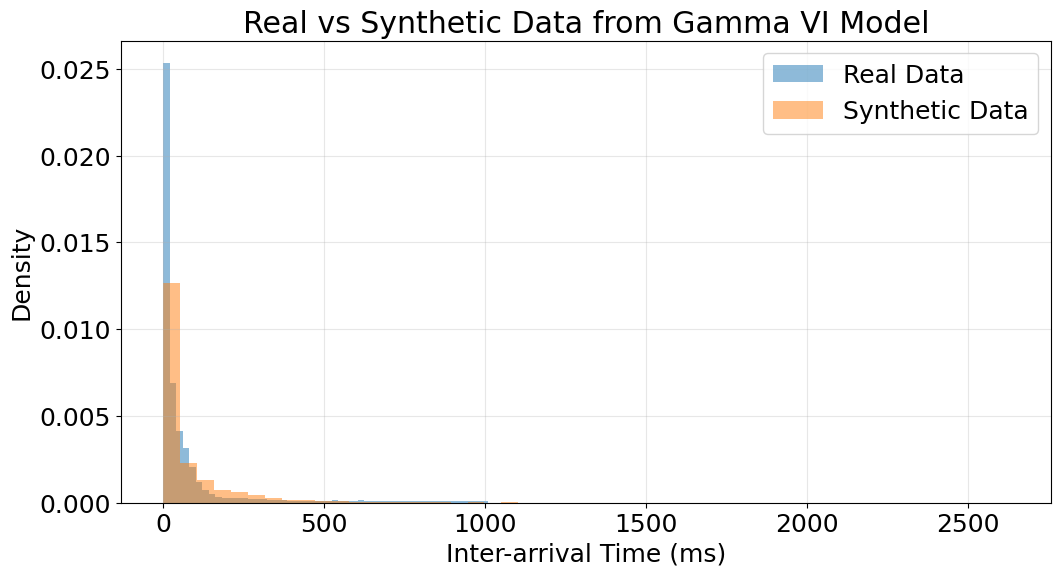

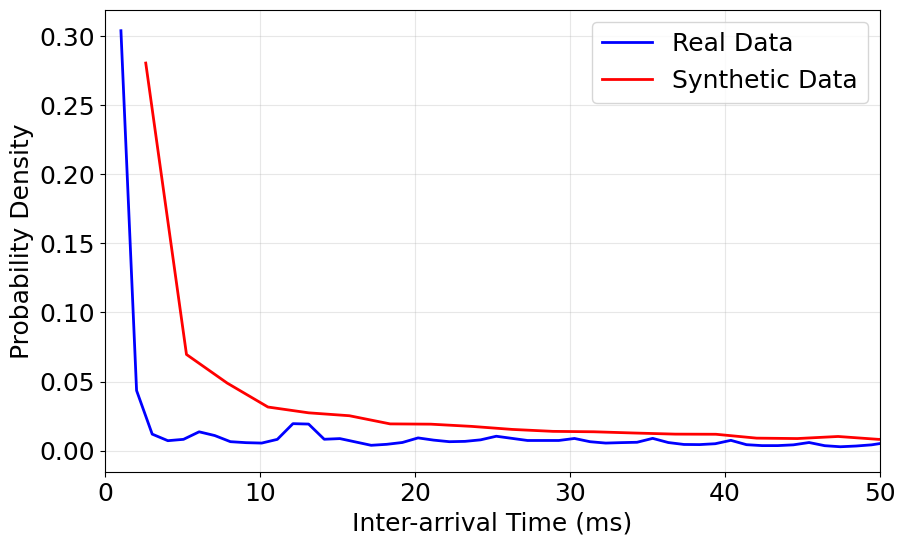

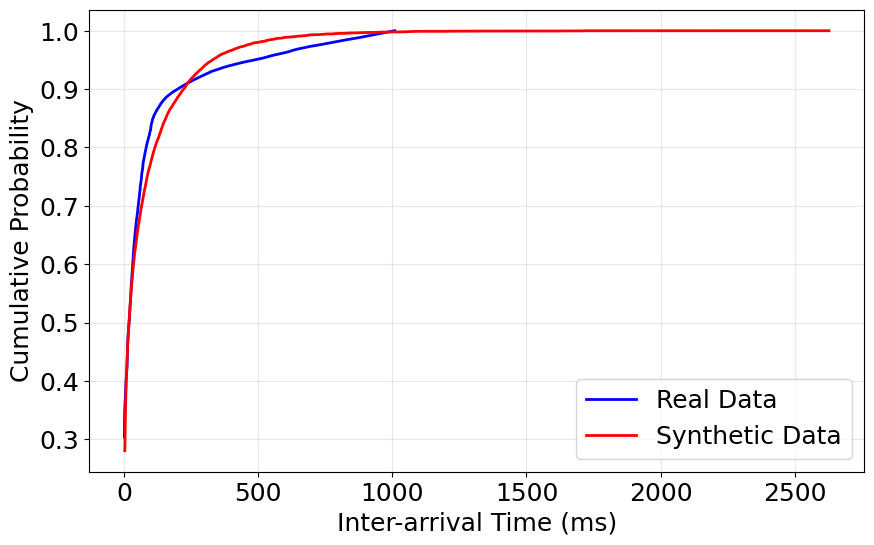

In [14]:
plt.rcParams.update({'font.size': 18})
def generate_synthetic_data(model_name, params, n_samples=10000):
    if model_name == "exponential":
        rate = params["rate"]
        synthetic_data = np.random.exponential(scale=1/rate, size=n_samples)
    elif model_name == "gamma":
        alpha = params["alpha"]
        beta = params["beta"]
        synthetic_data = np.random.gamma(shape=alpha, scale=1/beta, size=n_samples)
    
    return synthetic_data

# Generate synthetic data from the best model
model_name, method = best_model[0].split()
if method == "MAP":
    if model_name == "Exponential":
        best_params = exp_map_params
    else:  # Gamma
        best_params = gamma_map_params
else:  # VI
    if model_name == "Exponential":
        best_params = exp_vi_params
    else:  # Gamma
        best_params = gamma_vi_params

synthetic_data = generate_synthetic_data(model_name.lower(), best_params)

real_count, real_bins = np.histogram(filtered_data, bins=1000, density=True)
real_pdf = real_count / sum(real_count)
real_cdf = np.cumsum(real_pdf)
syn_count, syn_bins = np.histogram(synthetic_data, bins=1000, density=True)
syn_pdf = syn_count / sum(syn_count)
syn_cdf = np.cumsum(syn_pdf)

# Compare real vs synthetic data
plt.figure(figsize=(12, 6))
plt.hist(filtered_data, bins=50, alpha=0.5, density=True, label='Real Data')
plt.hist(synthetic_data, bins=50, alpha=0.5, density=True, label='Synthetic Data')
plt.title(f"Real vs Synthetic Data from {best_model[0]} Model")
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# PDF comparison plot
plt.figure(figsize=(10, 6))
plt.plot(real_bins[1:], real_pdf, 'b-', linewidth=2, label='Real Data')
plt.plot(syn_bins[1:], syn_pdf, 'r-', linewidth=2, label='Synthetic Data')
plt.xlim([0, 50])  # Focus on the first 50ms
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)
#plt.show()
plt.savefig("mv_dl_estvi_pdf.png")

# CDF
plt.figure(figsize=(10, 6))
plt.plot(real_bins[1:], real_cdf, 'b-', linewidth=2, label='Real Data')
plt.plot(syn_bins[1:], syn_cdf, 'r-', linewidth=2, label='Synthetic Data')
plt.xlabel("Inter-arrival Time (ms)")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid(True, alpha=0.3)
#plt.show()
plt.savefig("mv_dl_estvi_cdf.png")